<center> <a href="https://githubtocolab.com/felixp8/lfads-nlb-tutorials/blob/main/running_lfads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> </center>

# Running LFADS

Latent Factor Analysis via Dynamical Systems (Pandarinath et al. 2018), or LFADS, is a method using deep learning with artificial recurrent neural networks (RNNs) to model neural population activity. LFADS takes neural spiking data as an input and estimates the data's latent dynamics and de-noised neuron firing rates. No trial-specific information or behavioral information is required. When applied to a variety of datasets, the rates extracted by LFADS have been shown to estimate behavioral variables extremely well.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/lfads_nonvar_2.jpg?raw=true" width="800"></img></center>

This tutorial covers how to run LFADS using public repositories. It walks through:

1. Cloning the git repo and setting up a python environment to run LFADS
2. Structuring the H5 data file expected to run LFADS
3. Update a YAML file containing the hyperparameters for LFADS
4. Building a new LFADS model and training it on a dataset
5. Tuning LFADS hyperparameters with PBT
6. Loading a trained LFADS model and performing inference to get the model output
7. Performing synthetic data validation to ensure LFADS is working properly
8. Identifying common failure modes of LFADS and how to avoid them

The tutorial assumes some background knowledge of tbe LFADS architecture. For a tutorial covering that information, please see [Understanding LFADS]()

## Part 0: Setting up the environment

To begin modeling data with LFADS, we first need to setup our computing environment. 

If you are running the notebook locally, please follow the installation instructions in the `autolfads-tf2` GitHub [repository](https://github.com/snel-repo/autolfads-tf2).

If you are running in Google Colab, you need to:
1. **Set the correct Tensorflow version** 

> [Tensorflow](https://www.tensorflow.org/) is a deep learning framework developed by Google that we have used to design the LFADS implementation we will use in this tutorial.

2. **Clone the `autolfads-tf2` GitHub repository** 

> We will be using the public `autolfads-tf2` GitHub [repository](https://github.com/snel-repo/autolfads-tf2) developed by SNEL. 

3. **`pip install` all necessary Python dependencies** 

> This will ensure that all package dependencies that are needed to run `autolfads-tf2` are satistifed in the Colab environment

Running the below cell will get your environment setup!

In [1]:
#@title Import Dependencies

# check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
# suppresses logging of loading libcublas libraries                 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

if IN_COLAB:
    # install necessary packages 
    ! git clone https://github.com/snel-repo/autolfads-tf2.git
    os.chdir('autolfads-tf2')
    ! pip install -e lfads-tf2
    ! pip install -e tune-tf2
    os.chdir('..')
    ! git clone https://github.com/felixp8/lfads-nlb-tutorials.git
    os.chdir('lfads-nlb-tutorials')
    # add lfads_tf2
    os.environ['PYTHONPATH'] += ":/content/autolfads-tf2"
else:
    try:
        from lfads_tf2.utils import restrict_gpu_usage
    except:
        x = input('autolfads-tf2 is not installed. ' + 
            'We recommend setting up a conda environment and installing the package. ' + 
            'However, it can also be installed from the notebook. ' + 
            'Would you like to install it now? (y/n)'
        )
        if (x.strip() in ['Y', 'y']):
            ! git clone https://github.com/snel-repo/autolfads-tf2.git
            os.chdir('autolfads-tf2')
            ! pip install -e lfads-tf2
            ! pip install -e tune-tf2
            os.chdir('..')
            from lfads_tf2.utils import restrict_gpu_usage
        else:
            raise ImportError('Module `lfads_tf2` not found')

## Part 1: LFADS H5 Data

### 1.1. H5 Data Format

The expected data format of an LFADS HDF5 (H5) dataset contains the following fields:

1. `train_data`: training data set [ n_train_trials x n_time x n_dim ]
2. `valid_data`: validation data set [ n_valid_trials x n_time x n_dim ]
3. `train_inds`: indices of training data trials [ n_train_trials x 1 ]
4. `valid_inds`: indices of validation data trials [ n_valid_trials x 1 ]

Other fields can be added to the H5 file (e.g., `train_truth`, `valid_truth` if working with synthetic data) with no effect on model training.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/lfads_data.png?raw=true" width="800"></img></center>

### 1.2. Lorenz Synthetic Data

To understand how to use LFADS in this tutorial, we will be training our models on synthetic spiking data generated from a Lorenz system.

The advantage of using synthetically generated data, is that we have knowledge of both:
- the underlying dynamical system,
- and the true firing rates that generated the observed synthetic spiking activity  

Briefly, the process to generate synthetic data follows a series of steps:
1. Generate a random initial condition for the dynamical system and run the system forward in time for fixed time length
2. Use a linear transformation followed by a exponential nonlinearity to project the 3-dimensional Lorenz system into a 60-dimensional space representing the true firing rates of each "neuron".
3. Use Poisson sampling to generate spiking data from the true firing rates. 

> The synthetic data generation process is described in more detail in [Understanding LFADS](), which demonstrates how we generate synthetic spiking data from the Lorenz system.

Before we start training with LFADS, let's first take a look inside of the H5 dataset to see what the data looks like!

> **Note:** This cell will only load the data from the H5 file. No visualizations will be generated yet!

In [2]:
### Load dataset

data_path = 'data/lfads_lorenz.h5'

with h5py.File(data_path,'r') as h5file:
    h5dict = {key: h5file[key][()] for key in h5file.keys()}

# ==== REQUIRED FIELDS OF H5
# spiking data
train_spikes = h5dict['train_data'].astype(np.float32)
valid_spikes = h5dict['valid_data'].astype(np.float32)

# train/valid inds
train_inds = h5dict['train_inds'].astype(np.int32)
valid_inds = h5dict['valid_inds'].astype(np.int32)

# ==== ADDITIONAL FIELDS OF H5 (i.e., not required)
# true rates
train_truth = h5dict['train_truth'].astype(np.float32)
valid_truth = h5dict['valid_truth'].astype(np.float32)

# true lowd
train_lowd = h5dict['train_lowd'].astype(np.float32)
valid_lowd = h5dict['valid_lowd'].astype(np.float32)

# number of trials per init condition
n_trials_per_init_cond = h5dict['n_trials_per_init_cond'].astype(np.int32)[0]

# number of initial conditions
n_init_conds = h5dict['n_init_conds'].astype(np.int32)[0]

The H5 dataset for LFADS is saved with each data field split into `train_` and `valid_`. 

To recombine the dataset to undo the training/validation split, we can use the `train_inds` and and `valid_inds` return each trial to the correct index in the original dataset.


In [3]:
### Combine train and val splits

n_trials = n_trials_per_init_cond * n_init_conds

_, seq_len, data_dim = train_truth.shape
_, _, lowd_dim = train_lowd.shape

data_spikes = np.zeros((n_trials,seq_len,data_dim))
data_truth = np.zeros((n_trials,seq_len,data_dim))
data_lowd = np.zeros((n_trials,seq_len,lowd_dim))

data_spikes[train_inds,:,:] = train_spikes
data_spikes[valid_inds,:,:] = valid_spikes

data_truth[train_inds,:,:] = train_truth
data_truth[valid_inds,:,:] = valid_truth

data_lowd[train_inds,:,:] = train_lowd
data_lowd[valid_inds,:,:] = valid_lowd

### 1.3. Visualizing activity across neural population

Now that we've loaded the data, let's take a look at the data that will be input to LFADS -- the binned spiking activity. 

/home/fpei2/miniconda3/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


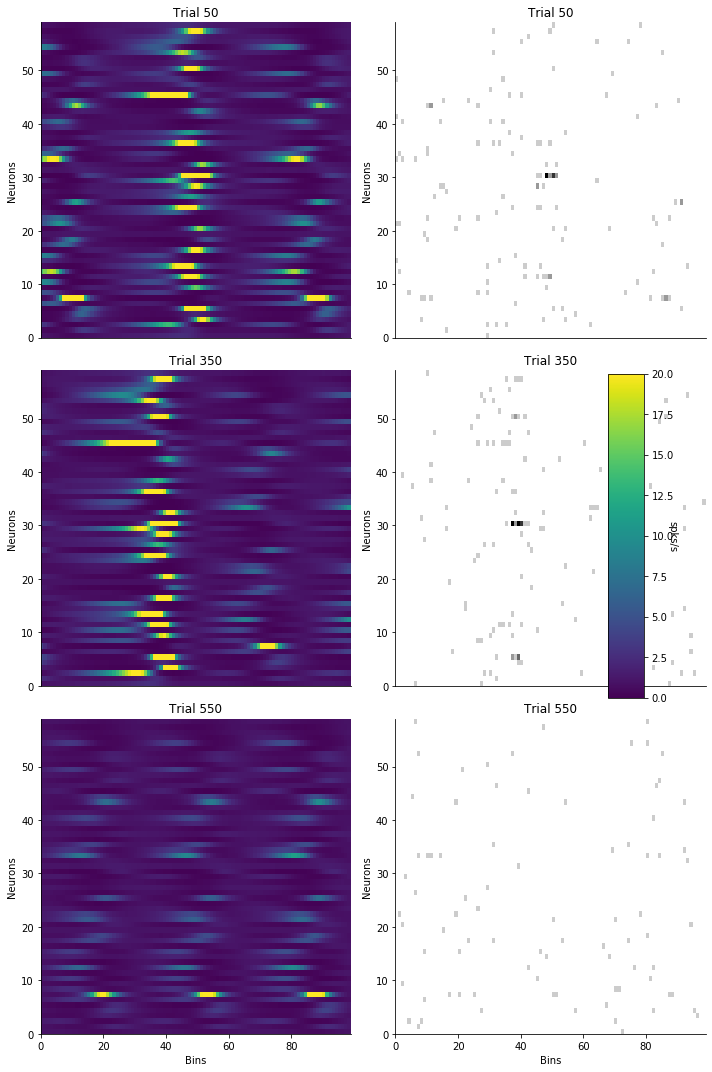

In [4]:
### Plot neural activity

trials = [ 50, 350, 550 ]
t = np.arange(data_truth.shape[1])
chans = np.arange(data_truth.shape[2])
X, Y = np.meshgrid(t, chans)
fig = plt.figure(figsize=(10,15))

for i, trial in enumerate(trials):
    ax1 = fig.add_subplot(len(trials),2,(2*i)+1)
    im = ax1.pcolor( X, Y, data_truth[trial,:,:].T, vmin=0, vmax=20)
    ax1.set_title('Trial ' + str(trial))
    ax2 = fig.add_subplot(len(trials),2,(2*i)+2)
    im2 = ax2.pcolor( X, Y, data_spikes[trial,:,:].T, cmap=cm.binary, vmin=0, vmax=5)  
    ax2.set_title('Trial ' + str(trial))
    if i == len(trials)-1:
        ax1.set_xlabel('Bins')
        ax2.set_xlabel('Bins')
    else:
        ax1.get_xaxis().set_visible(False)
        ax2.get_xaxis().set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_ylabel('Neurons')
    ax2.set_ylabel('Neurons')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.35, 0.02, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('spks/s', rotation=270)

## Part 2: Step-by-step setup of LFADS model training

### 2.1. Training a single LFADS model

We will first demonstrate how to train a single LFADS model. You can also find an example Python script for this [here](https://github.com/snel-repo/autolfads-tf2/blob/main/example_scripts/train_lfads.py).

#### 2.1.1. Importing the LFADS packages

First, we will import:

- Tensorflow
- hyperparameter and data handling functions (from *lfads_tf2.utils* and *lfads_tf2.defaults*)
- the `LFADS` model class (from *lfads_tf2.models*)
- other useful utilities

Importantly, if your machine has multiple GPUs and you do not want to use them all, you can use the function `restrict_gpu_usage` to limit LFADS to only use certain GPUs specified by index.

In [5]:
### Import LFADS packages

from lfads_tf2.utils import restrict_gpu_usage
restrict_gpu_usage(gpu_ix=0)

from lfads_tf2.models import LFADS
from lfads_tf2.utils import load_data, merge_chops, load_posterior_averages
from lfads_tf2.defaults import get_cfg_defaults

import os.path as path

### 2.1.2. Setup hyperparameter (HP) dictionary 

To train an LFADS model, we first need to instantiate it by setting the model hyperparameters (HPs). 

The model HPs contain specifications for:
- the architecture of the model (i.e., how large are the networks and feature representations)
- the regularization penalties (i.e., how much to penalize different components of the model)
- paths to load datasets and save model output
- training optimization specifications (i.e., initial learning rate, early stopping criteria)

There is a phenomenal breakdown of the LFADS hyperparameters and how they affect the model here: https://lfads.github.io/lfads-run-manager/hyperparameters/

With `lfads_tf2`, hyperparameters are specified in YAML files. The one we are using for this tutorial can be found [here](). The YAML file only needs to specify which values you would like to change from their default values, which are defined [here]().

### 2.1.3. Instantiate the LFADS model

We use the `LFADS` class to handle interacting with the model. An `LFADS` instance can be instantiated by providing a config file path, a path to a trained model directory, or a config node (which is an already loaded config file). The class then handles:
1. Setting hyperparameters from the config
2. Loading data from the file specified in the config
3. Rebuilding a model and loading its parameters if the model is already trained or instantiating the model if it isn't

In [6]:
### Build LFADS model

# cfg_path = path.join('models/config/', 'lorenz.yaml')
# model = LFADS(cfg_path=cfg_path)

### 2.1.4. Train the LFADS model 

Now we are ready to train an LFADS model! With `lfads_tf2`, all you need to do is call `model.train()`.

> **NOTE:** Running the below cell will take ~5 mins to train the model. The hyperparameters have not been set to optimize training performance. The below is only meant to give you an idea of what the training output looks like, and to show you that over training we are minimizing the reconstruction cost over training epochs and our model is reconstructing the true firing rates better (every 10 epochs, the model will return an R^2 value for the true firing rates reconstruction. This number should get increase toward 1 over training).

In [7]:
### Train model for a bit

# model.train()

### 2.2. Tuning LFADS hyperparameters with AutoLFADS

As you can see from the YAML config file and default config values, there are a lot of hyperparameters that can affect model performance. With substantial understanding of the hyperparameters and extensive supervised evaluation, those hyperparameters can be manually tuned iteratively to achieve good performance, but this process requires expertise and time.

As an alternative, SNEL has developed AutoLFADS, a framework that automatically tunes model hyperparameters through a method called Population-Based Training (PBT), shown below. PBT is an evolutionary algorithm that trains multiple models in parallel with randomly initialized hyperparameter values. After a certain period, it evaluates their performance and replaces the poorest models with copies of the best models. It then slightly perturbs hyperparameter values for the copied models and resumes training. This approach, combined with a regularization method called coordinated dropout (described in more detail in Part 4), finds high-performing LFADS models without any supervision, thus requiring no machine learning expertise from the user.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/pbt.png?raw=true" width="800"></img></center>

We will demonstrate how to set up and run AutoLFADS below. You can also find an example Python script [here](https://github.com/snel-repo/autolfads-tf2/blob/main/example_scripts/run_pbt.py).

> **Note:** AutoLFADS is computationally expensive and it is not recommended to try running it in a single-GPU Google Colab environment.

#### 2.2.1. Importing AutoLFADS packages

To run AutoLFADS, we need to import the following modules:
* `ray.tune`
* a function, `create_trainable_class` from `tune_tf2.models`, creating an LFADS wrapper for `ray.tune`
* PBT utilities from `tune_tf2.pbt`

In [8]:
### Import AutoLFADS packages

# import shutil
# from os import path

# import ray
# import yaml
# from lfads_tf2.utils import flatten
# from ray import tune
# from tune_tf2.models import create_trainable_class
# from tune_tf2.pbt.hps import HyperParam
# from tune_tf2.pbt.schedulers import MultiStrategyPBT
# from tune_tf2.pbt.trial_executor import SoftPauseExecutor

#### 2.2.2. Setting up AutoLFADS

Like with training a single LFADS model, we define config values using a YAML file. We also specify the directory to save all the models, where the data is loaded from, and resources to allocate to each model being trained.

After, we specify the hyperparameter ranges to search over in the variable `HYPERPARAM_SPACE`. These will overwrite values from the original config dict, so you do not need to worry about changing the values there.

In [9]:
### Configure AutoLFADS

# # the default configuration file for the LFADS model
# CFG_PATH = path.join('models/config/', "lorenz.yaml")
# # the directory to save PBT runs (usually '~/ray_results')
# PBT_HOME = path.expanduser("./ray_results")
# # the name of this PBT run (run will be stored at {PBT_HOME}/{PBT_NAME})
# RUN_NAME = "lorenz_run"  # the name of the PBT run
# # the dataset to train the PBT model on
# DATA_DIR = (
#     "data/"
# )
# DATA_PREFIX = "lfads"

# # the number of workers to use - make sure machine can handle all
# NUM_WORKERS = 2
# # the resources to allocate per model
# RESOURCES_PER_TRIAL = {"cpu": 2, "gpu": 0.5}
# # the hyperparameter space to search
# HYPERPARAM_SPACE = {
#     "TRAIN.LR.INIT": HyperParam(
#         1e-5, 5e-3, explore_wt=0.3, enforce_limits=True, init=0.004
#     ),
#     "MODEL.DROPOUT_RATE": HyperParam(
#         0.0, 0.6, explore_wt=0.3, enforce_limits=True, sample_fn="uniform"
#     ),
#     "MODEL.CD_RATE": HyperParam(
#         0.01, 0.7, explore_wt=0.3, enforce_limits=True, init=0.5, sample_fn="uniform"
#     ),
#     "TRAIN.L2.GEN_SCALE": HyperParam(1e-4, 1e-0, explore_wt=0.8),
#     "TRAIN.L2.CON_SCALE": HyperParam(1e-4, 1e-0, explore_wt=0.8),
#     "TRAIN.KL.CO_WEIGHT": HyperParam(1e-6, 1e-4, explore_wt=0.8),
#     "TRAIN.KL.IC_WEIGHT": HyperParam(1e-5, 1e-3, explore_wt=0.8),
# }
# PBT_METRIC = "smth_val_nll_heldin"
# EPOCHS_PER_GENERATION = 25

# # setup the data hyperparameters
# dataset_info = {"TRAIN.DATA.DIR": DATA_DIR, "TRAIN.DATA.PREFIX": DATA_PREFIX}
# # setup initialization of search hyperparameters
# init_space = {name: tune.sample_from(hp.init) for name, hp in HYPERPARAM_SPACE.items()}
# # load the configuration as a dictionary and update for this run
# flat_cfg_dict = flatten(yaml.full_load(open(CFG_PATH)))
# flat_cfg_dict.update(dataset_info)
# flat_cfg_dict.update(init_space)

#### 2.2.3. Running AutoLFADS

We then initialize an LFADS wrapper with `create_trainable_class`, the PBT scheduler, and a few other useful objects. We provide these to `tune.run`, which will handle training the models in parallel and distributing computational resources.

In [10]:
### Run AutoLFADS

# # Set the number of epochs per generation
# tuneLFADS = create_trainable_class(EPOCHS_PER_GENERATION)
# # connect to Ray cluster or start on single machine
# ray.init(address=None)
# # create the PBT scheduler
# scheduler = MultiStrategyPBT(HYPERPARAM_SPACE, metric=PBT_METRIC)
# # Create the trial executor
# executor = SoftPauseExecutor(reuse_actors=True)
# # Create the command-line display table
# reporter = tune.CLIReporter(metric_columns=["epoch", PBT_METRIC])
# try:
#     # run the tune job, excepting errors
#     tune.run(
#         tuneLFADS,
#         name=RUN_NAME,
#         local_dir=PBT_HOME,
#         config=flat_cfg_dict,
#         resources_per_trial=RESOURCES_PER_TRIAL,
#         num_samples=NUM_WORKERS,
#         sync_to_driver="# {source} {target}",  # prevents rsync
#         scheduler=scheduler,
#         progress_reporter=reporter,
#         trial_executor=executor,
#         verbose=1,
#         reuse_actors=True,
#     )
# except tune.error.TuneError:
#     pass

Once training is complete, we typically load the results of the run, identify the best model, and save it in a new directory.

In [11]:
### Identify and save best model

# # load the results dataframe for this run
# pbt_dir = path.join(PBT_HOME, RUN_NAME)
# df = tune.Analysis(pbt_dir).dataframe()
# df = df[df.logdir.apply(lambda path: "best_model" not in path)]
# # find the best model
# best_model_logdir = df.loc[df[PBT_METRIC].idxmin()].logdir
# best_model_src = path.join(best_model_logdir, "model_dir")
# # copy the best model somewhere easy to find
# best_model_dest = path.join(pbt_dir, "best_model")
# shutil.copytree(best_model_src, best_model_dest)

### 2.3. Loading a trained LFADS model

If we have trained an LFADS model, then we would like to be able to re-build the trained model and get the output when we pass through data. In `lfads_tf2`, as mentioned earlier, this is achieved by providing a model directory with a saved model to an `LFADS` instance at initialization. These model directories are created automatically when training LFADS or AutoLFADS.

In [12]:
### Load pre-trained model

model_dir = 'models/lfads_model/'
model = LFADS(model_dir=model_dir)

Loading model from models/lfads_model/.
Loading datasets with prefix lfads from data/
Restoring the LVE model.


## Part 3: Validating an LFADS model 

Now that we have trained the model, how do we know if it learned something meaningful? 

As we mentioned in the earlier sections, the advantage of testing LFADS on synthetic data is that you have ground truth knowledge of the underlying dynamics and the firing rates of all the channels. 

### 3.1. Performing inference with LFADS
We first need to pass data through the trained model and obtain its outputs. This is done with the function `sample_and_average`, which samples multiple outputs per input and averages them. By default, this function saves the output in a file that can then be loaded with `load_posterior_averages`.

In [13]:
### Perform inference on Lorenz spikes

# sample outputs from training data
model.sample_and_average()

# # to sample from data that was not trained on, you can first call 
# # load_datasets_from_file to load new data and then call sample_and_average:
# model.load_datasets_from_file(data_dir=data_dir, prefix=prefix)
# model.sample_and_average()
# # or you can directly provide the data to sample_and_average in a LoadableData instance

train_output, valid_output = load_posterior_averages(model_dir)

Removing existing posterior sampling file at models/lfads_model/posterior_samples.h5
Posterior sample and average on 640 segments.
640/640 [==================================================] - 27s 41ms/dataset
Posterior sample and average on 160 segments.
160/160 [==================================================] - 6s 35ms/dataset


The returned outputs have several fields. The most important are:
1. `rates`: Firing rate estimates for each channel, in the shape (batch x time x channel_dim)
2. `factors`: A linear projection of the generator RNN states that capture the modeled dynamical system (batch x time x factor_dim)

The others are typically less useful, but for completeness, they are:

3. `gen_states`: The actual generator RNN states, typically higher-dimensional than `factors` to create a bottleneck (batch x time x generator_dim)
4. `gen_inputs`: Inputs to the generator RNN, output from the controller (batch x time x controller_dim)
5. `gen_init`: The initial conditions of the generator (batch x gen_dim)
6. `ic_post_mean`: Means of the initial condition (IC) posterior output by the encoder (batch x ic_dim)
7. `ic_post_logvar`: Log-variance for the IC posterior output by encoder (batch x ic_dim)
8. `ic_prior_mean`: Means for the IC prior, always set to 0 (in my experience) (batch x ic_dim)
9. `ic_prior_logvar`: Log-variance for the IC prior, typically set to $\ln{0.1} = -2.303$ (batch x ic_dim)

The fields can be indexed from `train_output` and `valid_output` or accessed with `<train/val>_output.<field_name>`, for example `train_output.rates`.

Before we move to plotting, we want to merge the train and valid outputs to restore the original data trial order, as we did in section 1.2. This can also be done with the parameter `merge_tv` in `load_posterior_averages`, but we'll just do it manually here.

In [14]:
### Merge train and valid splits for inference output

train_rates, train_factors, *_ = train_output
valid_rates, valid_factors, *_ = valid_output

factor_dim = train_factors.shape[-1]

model_rates = np.zeros((n_trials,seq_len,data_dim))
model_factors = np.zeros((n_trials,seq_len,factor_dim))

model_rates[train_inds,:,:] = train_rates
model_rates[valid_inds,:,:] = valid_rates

model_factors[train_inds,:,:] = train_factors
model_factors[valid_inds,:,:] = valid_factors

### 3.2. Visualization of single trial population firing rates
We can do a simple visual comparison to see if the LFADS-inferred firing rates resemble the true rates used to generate the spiking activity. 

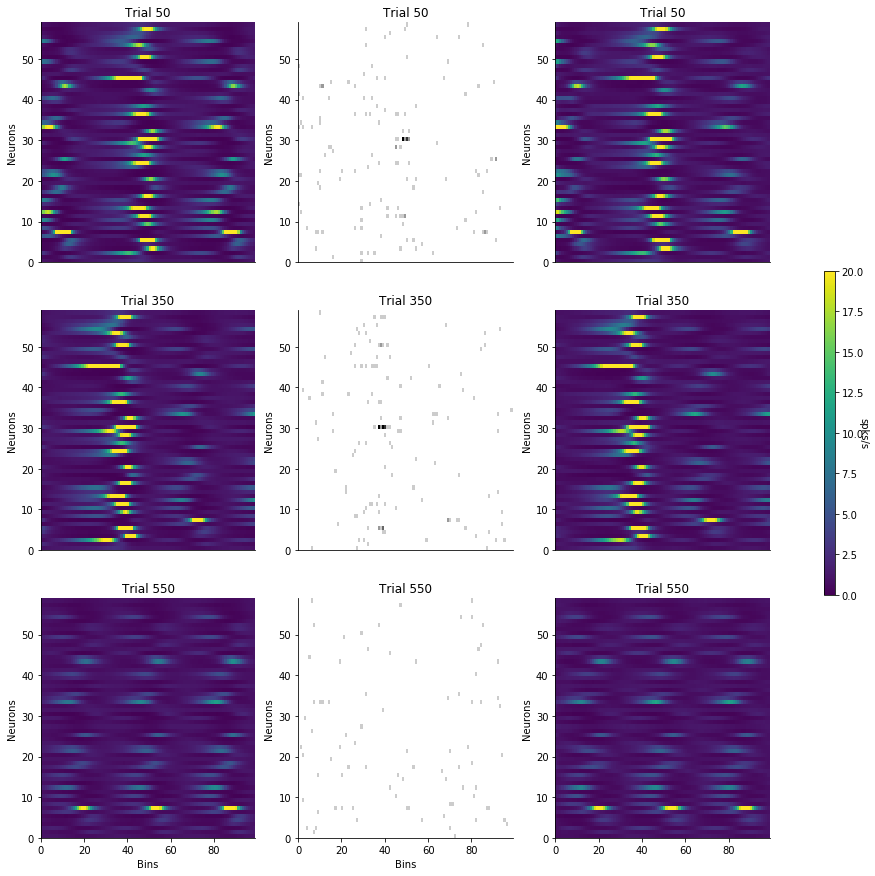

In [15]:
### Plot model inference

dt = 0.010
fig = plt.figure(figsize=(15,15))
for i, trial in enumerate(trials):
    title_str = 'Trial ' + str(trial)
    ax1 = fig.add_subplot(len(trials),3,(3*i)+1)
    im = ax1.pcolor( X, Y, data_truth[trial,:,:].T, vmin=0, vmax=20)
    ax1.set_title(title_str)
    ax2 = fig.add_subplot(len(trials),3,(3*i)+2)
    im2 = ax2.pcolor( X, Y, data_spikes[trial,:,:].T, cmap=cm.binary, vmin=0, vmax=5)
    ax2.set_title(title_str)
    ax3 = fig.add_subplot(len(trials),3,(3*i)+3)
    im3 = ax3.pcolor( X, Y, model_rates[trial,:,:].T/dt, vmin=0, vmax=20)   
    #im = ax.imshow(train_truth[trial,:,:])
    ax3.set_title(title_str)
    if i == len(trials)-1:
        ax1.set_xlabel('Bins')
        ax2.set_xlabel('Bins')
    else:
        ax1.get_xaxis().set_visible(False)
        ax2.get_xaxis().set_visible(False)
        ax3.get_xaxis().set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax1.set_ylabel('Neurons')  
    ax2.set_ylabel('Neurons')
    ax3.set_ylabel('Neurons')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('spks/s', rotation=270)

Above we are showing three columns:

(left) the **true firing rates** underlying the synthetic spiking activity

(middle) the **spiking activity** (i.e., input to the LFADS model)

(right) the **LFADS-inferred firing rates** (i.e., output of the LFADS model)

The similarity between the left and right columns demonstrate the power of applying a dynamical systems modeling approach to de-noise spiking activity. Even though the input to the LFADS model is represented by the middle column, modeling the underlying dynamics in the data allows us to recover accurate estimates of the true firing rates.  

### 3.3. Model reconstruction of Lorenz dynamics

Another way we can validate our LFADS model is asking how well the underlying dynamical system can map onto the true dynamical system (i.e., Lorenz system). If we accurately modeled the dynamics using LFADS, then we expect that the model factors can map onto the original dimensions of the Lorenz system. 

Below we setup this analysis by:

1. Flattening the LFADS model factors and the true Lorenz dynamics to give us two arrays with shape [ n_samples x n_dim ]
2. Fit an affine transformation (i.e., scaling, rotation, translation) from the model factors onto the Lorenz dynamics 
3. Compare the accuracy of the prediction of the Lorenz dynamics from the model factors using R^2 (via `sklearn.metric.r2_score`)

R^2 Low-D reconstruction:[0.98789634 0.98158277 0.95369228]


Text(0.5, 0.98, 'Model Reconstruction of Dynamics')

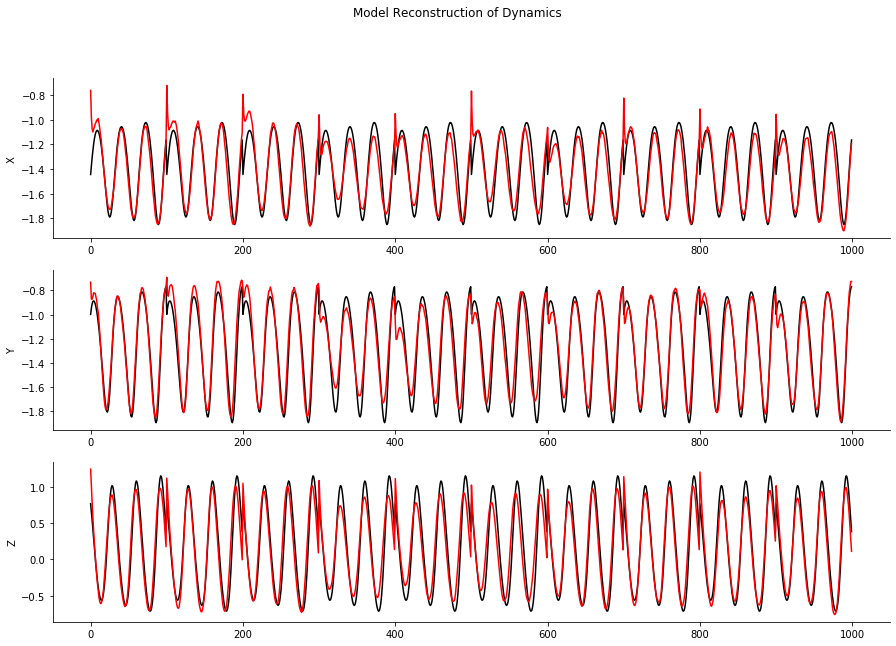

In [16]:
### Evaluate model reconstruction of dynamics

# flatten factors and lowd dynamics
factors_dim = model_factors.shape[2]
# model_factors_flat = model_factors.transpose(2,0,1).reshape((factors_dim,-1)).T
# lowd_flat = data_lowd.transpose(2,0,1).reshape(lowd_dim, -1).T
model_factors_flat = model_factors.reshape(-1, factors_dim)
lowd_flat = data_lowd.reshape(-1, lowd_dim)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# lowd reconstruction
lin_reg = LinearRegression()
# fit transformation from factors -> lowd
lin_reg.fit(model_factors_flat, lowd_flat)
model_lowd_pred_flat = lin_reg.predict(model_factors_flat)

# calculate r^2 of predictions 
r2_lowd_recon = r2_score(lowd_flat, model_lowd_pred_flat, multioutput='raw_values')

fig = plt.figure(figsize=(15,10))

plt_range = 1000
ylabs = ['X', 'Y', 'Z']
print('R^2 Low-D reconstruction:' +str(r2_lowd_recon))
for i in range(lowd_dim):
    ax = fig.add_subplot(3,1,i+1)
    ax.plot(lowd_flat[:plt_range,i], color='k')
    ax.plot(model_lowd_pred_flat[:plt_range,i], color='r')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabs[i])
plt.suptitle('Model Reconstruction of Dynamics')

Above, we show the prediction of the Lorenz dynamics from the model factors (red) overlaid on the true Lorenz dynamics (black). R^2 > 0.9 for the three dimensions suggests that the dynamics were accurately reconstructed using LFADS, which is apparent from the above visualization.
> **Note:** You may notice above that there are certain timepoints where the prediction from the model factors seems poor (e.g., look at x=400). Remember that the sequence length of the model is 100 steps and we have concatenated all the trials together to flatten them. The timepoints where the prediction is poor are the points where the sequence passed to LFADS started. the beginning of the sequence modeled by LFADS can be slightly off since it takes a few timesteps for the RNN to stabilize from the initial state.

Text(0.5, 0.92, 'LFADS-inferred trajectories for Lorenz system')

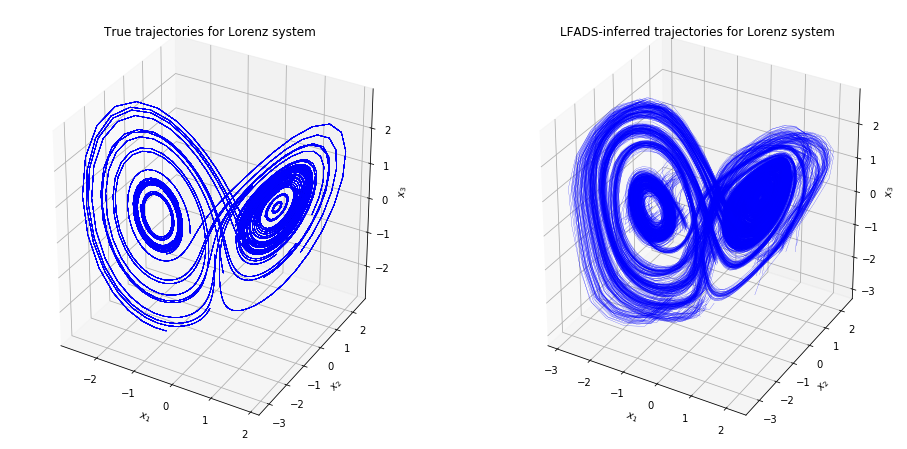

In [17]:
### Plot reconstructed dynamics in 3d

fig = plt.figure(figsize=(16,8))

model_lowd_pred = model_lowd_pred_flat.reshape(data_lowd.shape)
trial_num = model_factors.shape[0]

ax = fig.add_subplot(1, 2, 1, projection='3d')
for i in range(trial_num):
    ax.plot3D(data_lowd[i,:,0], data_lowd[i,:,1], data_lowd[i,:,2],'b', linewidth=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('True trajectories for Lorenz system')

ax = fig.add_subplot(1, 2, 2, projection='3d')
for i in range(trial_num):
    ax.plot3D(model_lowd_pred[i,:,0], model_lowd_pred[i,:,1], model_lowd_pred[i,:,2],'b', linewidth=0.2)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('LFADS-inferred trajectories for Lorenz system')

## Part 4: Failure Modes of LFADS

Now that we have learned how to train an LFADS model and evaluate the quality of the model when trained on synthetic data, the last part of this tutorial will cover potential failure modes of LFADS. There are two cases we will cover below: 

- What does it look like if the model has **overfit**?
- What does it look like if the model has **underfit**? 

In this section, we will be looking at pre-trained models that will show how the model output can look it susceptible to these specific failure modes. 

### 4.1. Loading pre-trained models

First, we will load two pre-trained models:
- `lfads_overfit`: A model that will demonstrate what it looks like when LFADS overfits to the spiking activity
- `lfads_underfit`: A model that demonstrates what it looks like when LFADS is incapable of modeling the underlying dynamics in the data

In [18]:
### Load overfit model

model_dir = 'models/lfads_overfit/'
overfit_model = LFADS(model_dir=model_dir)

Loading model from models/lfads_overfit/.
The `model_dir` in the config file doesn't match the true model directory. Updating and saving new config.
Loading datasets with prefix lfads from data/
Restoring the LVE model.


In [19]:
### Load underfit model

model_dir = 'models/lfads_underfit/'
underfit_model = LFADS(model_dir=model_dir)

Loading model from models/lfads_underfit/.
The `model_dir` in the config file doesn't match the true model directory. Updating and saving new config.
Loading datasets with prefix lfads from data/
Restoring the LVE model.


### 4.2. Visual comparison of population firing rates from pre-trained models
Now that we have loaded the output from each model, we will extract the inferred firing rates and the factors from each model. 

Then we will generate a similar visualization shown in Section 2.2.1 to compare the firing rates from each model to the true firing rates and observed spiking activity. 

Posterior sample and average on 640 segments.
640/640 [==================================================] - 24s 38ms/dataset
Posterior sample and average on 160 segments.
160/160 [==================================================] - 6s 38ms/dataset
Posterior sample and average on 640 segments.
640/640 [==================================================] - 22s 34ms/dataset
Posterior sample and average on 160 segments.
160/160 [==================================================] - 6s 35ms/dataset


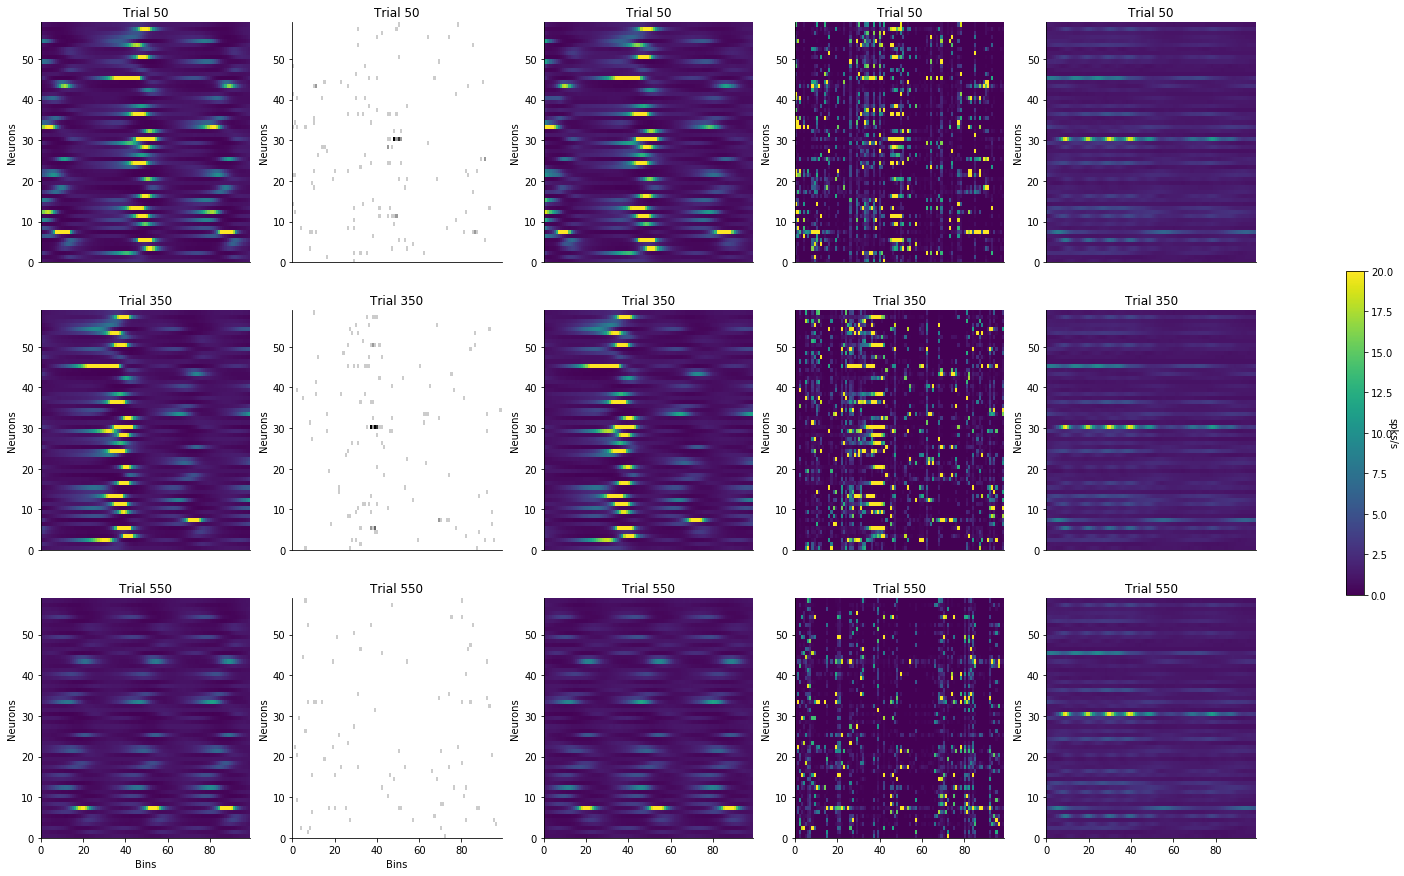

In [20]:
### Plot overfit and underfit model outputs

# extract model factors/inferred firing rates
model_rates_overfit, model_factors_overfit, *_ = overfit_model.sample_and_average(save=False, merge_tv=True)

model_rates_underfit, model_factors_underfit, *_ = underfit_model.sample_and_average(save=False, merge_tv=True)

dt = 0.010
ncols = 5
fig = plt.figure(figsize=(25,15))
for i, trial in enumerate(trials):
    title_str = 'Trial ' + str(trial)
    ax1 = fig.add_subplot(len(trials),ncols,(ncols*i)+1)
    im = ax1.pcolor( X, Y, data_truth[trial,:,:].T, vmin=0, vmax=20)
    #ax2.set_title('Trial ' + str(trial))
    ax2 = fig.add_subplot(len(trials),ncols,(ncols*i)+2)
    im2 = ax2.pcolor( X, Y, data_spikes[trial,:,:].T, cmap=cm.binary, vmin=0, vmax=5)
    ax3 = fig.add_subplot(len(trials),ncols,(ncols*i)+3)
    im3 = ax3.pcolor( X, Y, model_rates[trial,:,:].T/dt, vmin=0, vmax=20)
    ax4 = fig.add_subplot(len(trials),ncols,(ncols*i)+4)
    im4 = ax4.pcolor( X, Y, model_rates_overfit[trial,:,:].T/dt, vmin=0, vmax=20)   
    ax5 = fig.add_subplot(len(trials),ncols,(ncols*i)+5)
    im5 = ax5.pcolor( X, Y, model_rates_underfit[trial,:,:].T/dt, vmin=0, vmax=20)  
    ax1.set_title(title_str)    
    ax2.set_title(title_str)
    ax3.set_title(title_str)
    ax4.set_title(title_str)
    ax5.set_title(title_str)
    #ax3.set_title('Trial ' + str(trial))
    if i == len(trials)-1:
        ax1.set_xlabel('Bins')
        ax1.set_ylabel('Neurons')
        ax2.set_xlabel('Bins')
        ax2.set_ylabel('Neurons')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        ax4.spines['right'].set_visible(False)
        ax5.spines['top'].set_visible(False)
        ax5.spines['right'].set_visible(False)
    else:
        ax1.get_xaxis().set_visible(False)
        ax2.get_xaxis().set_visible(False)
        ax3.get_xaxis().set_visible(False)
        ax4.get_xaxis().set_visible(False)
        ax5.get_xaxis().set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)

    ax1.set_ylabel('Neurons')  
    ax2.set_ylabel('Neurons')
    ax3.set_ylabel('Neurons')
    ax4.set_ylabel('Neurons')
    ax5.set_ylabel('Neurons')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('spks/s', rotation=270)

Above we are showing 5 columns (from left to right):

(1) the **true firing rates** 

(2) the **spiking activity** 

(3) the "goodfit" **LFADS-inferred firing rates** 

(4) the "overfit" **LFADS-inferred firing rates** 

(5) the "underfit" **LFADS-inferred firing rates** 

Focusing on columns (3)-(5) show the differences between LFADS models. 


- The "goodfit" LFADS-inferred firing rates (column 3) look very similar to the true firing rates. 

- The "overfit" LFADS-inferred firing rates (column 4) have spiky features that are not present in the true firing rates. Instead, if we look at the input spiking activity, we see that the model has managed to generate the spiking activity to achieve better reconstruction costs on the data input to the model, at the expense of worse reconstruction of the true firing rates underlying the noisy activity.

- The "underfit" LFADS-inferred firing rates (column 5) have a burst of activity at the beginning of the trial and then are flat throughout the remainder of the sequence. When the model output looks like this, it is a sign that the model training did not learn a dynamical system that can explain the data well. 

### 4.3. How to prevent failure modes of LFADS

#### **Overfitting**
- To generate the overfit model, we turned off dropout on the Generator RNN hidden states and coordinated dropout, a regularization strategy designed for LFADS to specifically combat the pathological overfitting issues that happen when fitting sequential autoencoders (see Appendix). 
- We also increased the number of outputs of the controller, making it easier for the model to use the controller to pass spikes into the generator. 

**General strategy to avoid overfitting** 
- Turn on coordinated dropout (i.e., `CD_RATE > 0`)
- Turn on dropout on the Generator RNN hidden states (i.e., `DROPOUT_RATE > 0`)
- Reduce the number of controller outputs (i.e., set `CO_DIM` to be small)

#### **Underfitting**
- To generate the underfit model, we increased the KL penalties on the initial condition distributions and controller output distribution to be order of magnitudes higher than what is typically used (around `1e-6` to `1e-4`). 
- We also increased the L2 penalties on the generator RNN and controller RNN recurrent kernels, which regularizes the complexity of the underlying dynamics modeled by two RNNs

**General strategy to avoid underfitting**
- If the model is underfitting, this is typically a sign that the LFADS model lacks the capacity necessary to explain the data. 
- A good first check is to turn off all regularizers in the model (i.e., dropout `keep_prob=1.0`, coordinated dropout `keep_ratio=1.0`, KL/L2 penalities `kl_ic_weight=0` `kl_co_weight=0`, `l2_gen_scale=0` `l2_con_scale=0`) and confirm that you can overfit to the dataset. This would confirm that the architecture of the model is not limiting your power of your model. 
- Lower the KL/L2 penalties from the values used when the model underfit. 
- Reduce the probability of dropout `DROPOUT_RATE` on the generator RNN hidden states to allow more information to pass through the generator. 


#### **AutoLFADS: Automatic hyperparameter optimization of LFADS models**

Avoiding failure modes of LFADS typically requires careful tuning of the model hyperparameters to properly regularize LFADS to learn meaningful dynamics. While manual tuning may be a suitable approach for initial testing, performing hyperparameter searches are a principled way of finding suitable HP's to model your data. AutoLFADS is an automatic hyperparameter optimization framework for LFADS that uses evolutionary algorithms to find the optimal hyperparameters for LFADS over an iterative training process. However, general guidelines like those above can help you adjust your search ranges if you observe underfitting or overfitting.


## Summary and Conclusions

In this tutorial, we walked through how to train an LFADS model from scratch, and gather the output from a model after training. We validated an LFADS model on synthetic data to demonstrate the capability of LFADS to de-noise spiking activity and infer firing rates underlying the observed spiking activity that reflect the true underlying dynamics used to generate the data. 

Hopefully, this notebook gave you a hands-on example to get comfortable running LFADS and can serve as a reference point to get LFADS running on your own data! 

## Appendix

### A.1. Coordinated Dropout

Coordinated dropout is a regularization technique for autoencoders of spiking activity, proposed for LFADS in [Keshtkaran & Pandarinath, 2019](). Because spiking data is so sparse, even a tight bottleneck may still allow the model to directly encoder exact spike times instead of approximating the latent dynamics. This overfitting mode is just as effective on validation data as it is for training data, so it is not detectable by typical approaches of comparing training and validation loss. 

Coordinated dropout addresses this by randomly masking certain points (i.e. a single channel at a single timepoint) at the input end and only training the model on its abilities to predict activity at those masked points. As a result, the model never learns from spikes it sees as input, and instead needs to accurately predict the presence of masked spikes just from the remaining data. This is depicted in the following diagram. 

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/coord_dropout.png?raw=true" width="800"></img></center>